# PySpark Example Project

In [ ]:
Nhóm 6:
    Lê Thế Nam       20173265
    Nguyễn Tuấn Hiệp 20170070
    Phạm Thanh Phong 20173300

https://github.com/trungtv/pyspark-example-project

Project trên minh họa một ví dụ đơn giản để thực hành với pyspark khởi tạo một ETL jobs sử dụng Apache Spark.  
`ETL (Extract | Transform | Load)` jobs thực hiện việc đọc dữ liệu từ nguồn vào, thường là các cơ sở lưu trữ dữ liệu lớn, thực hiện các phép 
biến đổi rồi lưu lại vào đầu ra. Các hành động này nên được thiết kế tuần tự để tránh các tác nhân khác ảnh hưởng tới quá trình. 

+ Import các thư viện cơ bản  
Lưu ý khi chạy code mẫu, cần đặt các thư mục `dependencies` và `configs` cùng mục với file `python`.  

In [6]:
from findspark import init
init()
from pyspark.sql import Row
from pyspark.sql.functions import col, concat_ws, lit
from dependencies.spark import start_spark

## Bước khởi tạo  

Khởi tạo spark session, logger và các file config.  

In [7]:
spark, log, config = start_spark(
        app_name='my_etl_job',
        files=['configs/etl_config.json'])

In [8]:
config

{'steps_per_floor': 21}

## Extract data  

Tiến hành đọc dữ liệu từ đầu vào. Trong ví dụ này, chúng ta sẽ tiến hành load dữ liệu từ file `parquet`, một dạng file `Columnar storage` giúp chúng ta truy vấn nhanh hơn và tiếp kiệm bộ nhớ hơn trong nhiều trường hợp.  

In [11]:
def extract_data(spark):
    """Load data from Parquet file format.

    :param spark: Spark session object.
    :return: Spark DataFrame.
    """
    df = (
        spark
        .read
        .parquet('tests/test_data/employees'))

    return df

data = extract_data(spark)
data.show()

+----------+-----+---+-----------+
|first_name|floor| id|second_name|
+----------+-----+---+-----------+
|       Dan|    1|  1|    Germain|
|       Dan|    1|  2|Sommerville|
|      Alex|    2|  3|  Ioannides|
|       Ken|    2|  4|        Lai|
|       Stu|    3|  5|      White|
|      Mark|    3|  6|   Sweeting|
|      Phil|    4|  7|       Bird|
|       Kim|    4|  8|      Suter|
+----------+-----+---+-----------+



## Transform data 

Thực hiện các thao tác biến đổi trên data frame vừa thu được.   
Ex : Ghép tên với họ và tính số bước chân để tới được chỗ ngồi.

In [12]:
def transform_data(df, steps_per_floor_):
    """Transform original dataset.

    :param df: Input DataFrame.
    :param steps_per_floor_: The number of steps per-floor at 43 Tanner
        Street.
    :return: Transformed DataFrame.
    """
    df_transformed = (
        df
        .select(
            col('id'),
            concat_ws(
                ' ',
                col('first_name'),
                col('second_name')).alias('name'),
               (col('floor') * lit(steps_per_floor_)).alias('steps_to_desk')))

    return df_transformed

In [13]:
data_transformed = transform_data(data, config['steps_per_floor'])
data_transformed.show()

+---+---------------+-------------+
| id|           name|steps_to_desk|
+---+---------------+-------------+
|  1|    Dan Germain|           21|
|  2|Dan Sommerville|           21|
|  3| Alex Ioannides|           42|
|  4|        Ken Lai|           42|
|  5|      Stu White|           63|
|  6|  Mark Sweeting|           63|
|  7|      Phil Bird|           84|
|  8|      Kim Suter|           84|
+---+---------------+-------------+



## Load data  
Lưu trữ data vào đầu ra tùy chỉnh, trong trường này là file CSV.  

In [14]:
def load_data(df):
    """Collect data locally and write to CSV.

    :param df: DataFrame to print.
    :return: None
    """
    (df
     .coalesce(1)
     .write
     .csv('loaded_data', mode='overwrite', header=True))
    return None

In [15]:
load_data(data_transformed)

## Deploy Application 

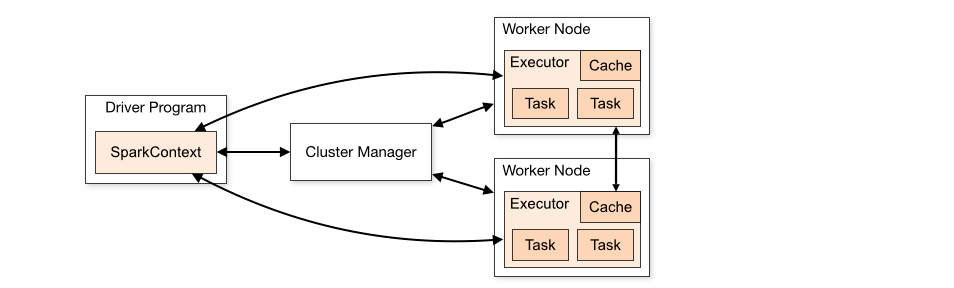

Spark cho phép các tiến trình chạy độc lập trong các cluster(cụm). Spark có thể hoạt động tốt trên rất nhiều trình quản lí cluster khác nhau. Spark sẽ yêu cầu các trình quản lí các worker để thực hiện các task được giao từ `SparkContext`.   
 + Standalone
 + Apache Mesos
 + Hadoop YARN 
 + Kubernetes  


### Standalone mode 

Đây là cluster manager đơn giản nhất, được tích hợp sẵn với Apache Spark khi cài đặt.  
 + Khởi tạo `Master node` để quản lí các tiến trình.  

Khởi chạy với lệnh :  
```
$SPARK_HOME/sbin/start-master.sh
```

Sau đó, chúng ta có thể truy cập vào link `http://localhost:8080` để vào giao diện quản lí master.  

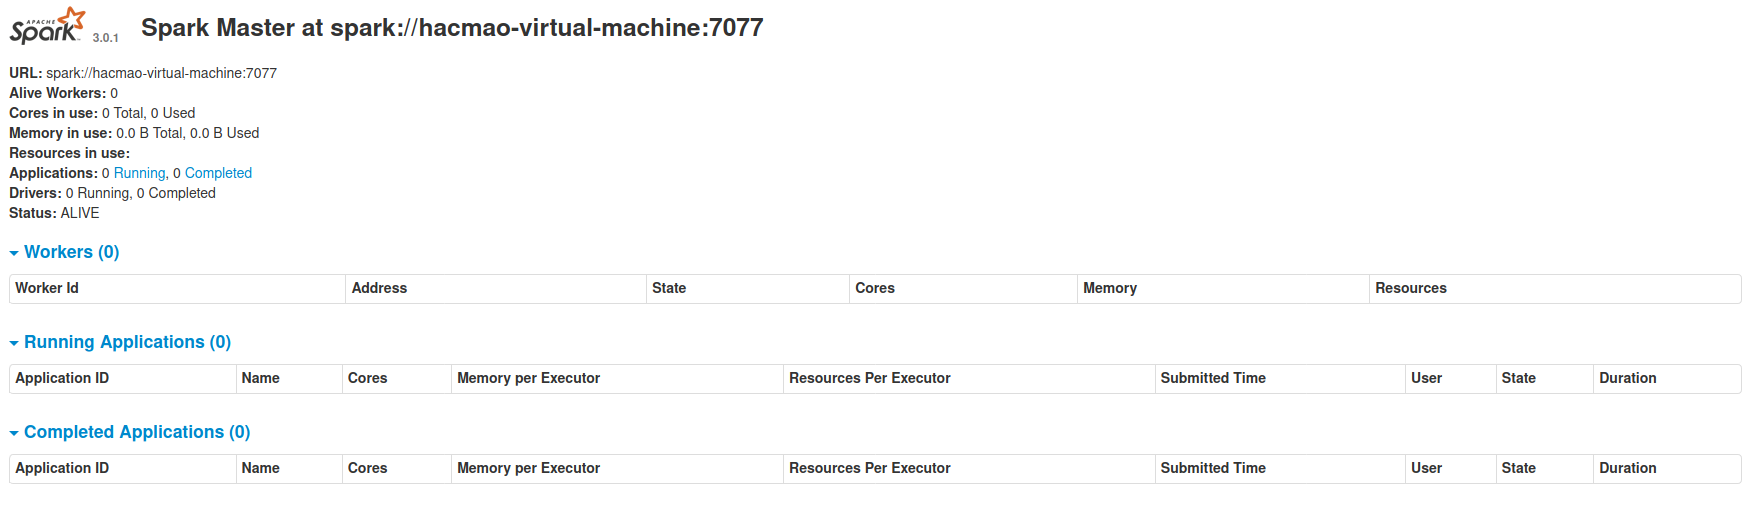  

Nhận đường link của master

 + Khởi tạo worker :   

```
SPARK_HOME/sbin/start-slave.sh <master-url>
```



+ Chuyển ứng dụng lên `master` bằng `spark-submit`  

```
$SPARK_HOME/bin/spark-submit \
--master <master-url> \
--py-files packages.zip \
--files configs/etl_config.json \
jobs/etl_job.py 
```

   - `--py-files` : package importr của chương trình
   - `--files` : khai báo file config
   - `jobs/etl_job.py` : đường dẫn tới file thực thi chính  

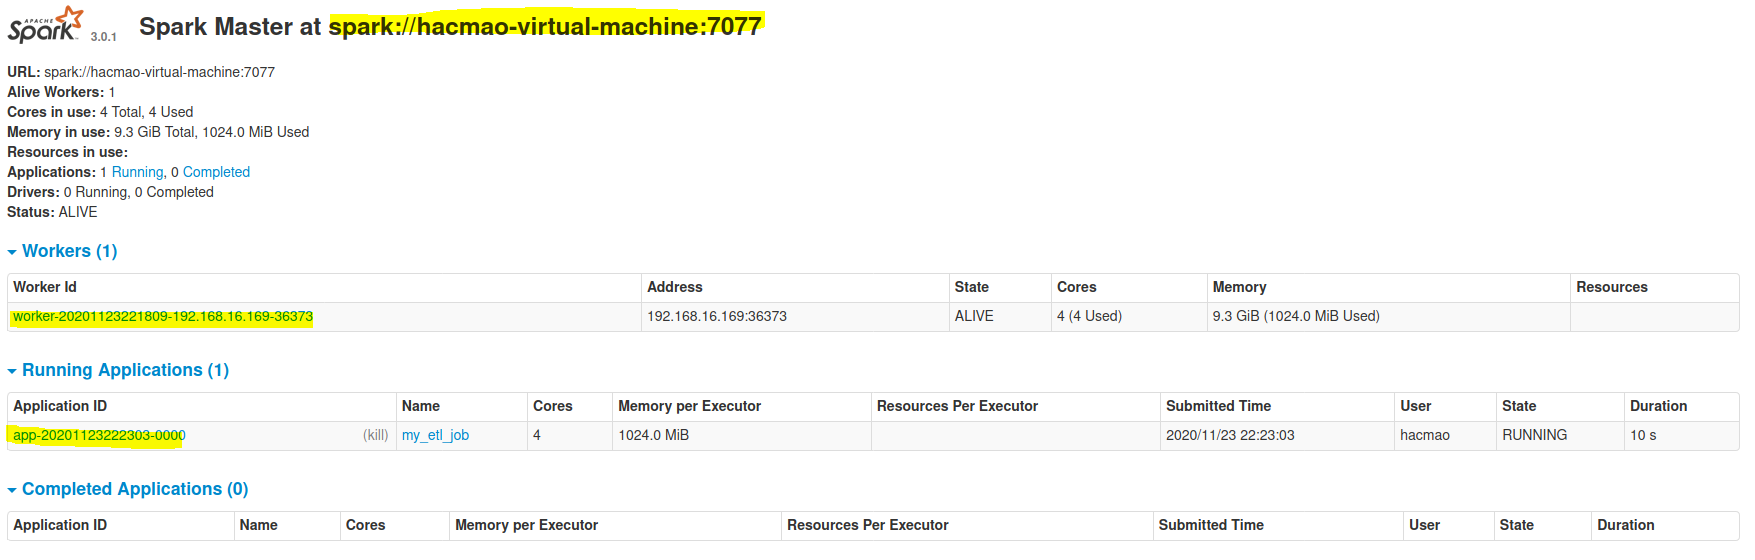